In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('pd_speech_features.csv')
df.drop('id', axis=1, inplace=True)

In [3]:
scaler = MinMaxScaler()
df[df.columns[:]] = scaler.fit_transform(df[df.columns[:]])

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print('Number of data in each class :')
print('before split : ',Counter(y))

Number of data in each class :
before split :  Counter({1.0: 564, 0.0: 192})


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('before balancing : ',Counter(y_train))


from imblearn.over_sampling import SMOTE

SMOTE = SMOTE(sampling_strategy='minority')
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)
print('after balancing (over_sampling) : ',Counter(y_train_SMOTE))

before balancing :  Counter({1.0: 398, 0.0: 131})
after balancing (over_sampling) :  Counter({1.0: 398, 0.0: 398})


## PCA

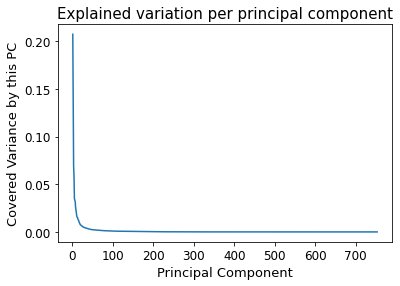

In [6]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)

X_train_transformed = pca.fit_transform(X_train_SMOTE)
X_test_transformed = pca.transform(X_test)

n = np.arange(1, len(pca.explained_variance_ratio_)+1)

plt.figure()
#plt.figure(figsize=(6,5))
plt.plot(n, pca.explained_variance_ratio_)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Principal Component',fontsize=13)
plt.ylabel('Covered Variance by this PC',fontsize=13)
plt.title("Explained variation per principal component",fontsize=15)
plt.show()

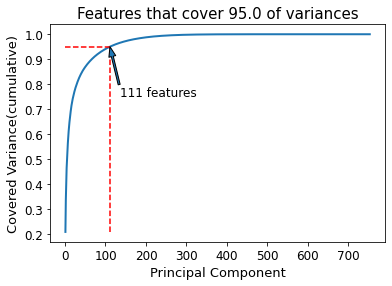

In [7]:
cumulative = np.cumsum(pca.explained_variance_ratio_)
i = 0
while cumulative[i] <0.95:
    i = i+1
val = cumulative[i]
index = i

n = np.arange(1 , len(pca.explained_variance_ratio_) + 1)
plt.plot(n , cumulative, lw=2)
plt.plot(np.arange(1 , index+1),np.full((index,1),val),'--' ,color='red')
plt.plot(np.full((index,1),index),np.linspace(cumulative[0],val,index),'--' , color='red')
plt.annotate(str(index+1)+' features', xy=(index+1 ,val), xytext=(135,0.75), arrowprops = dict(width=2 ,headlength=10 ,headwidth=7), fontsize=12)
plt.title('Features that cover '+ str(round(val*100,2))+' of variances',fontsize=15)
plt.xlabel('Principal Component',fontsize=13)
plt.ylabel('Covered Variance(cumulative)',fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [8]:
pca1 = PCA(n_components=index+1, whiten=True)

X_train_transformed = pca1.fit_transform(X_train_SMOTE)
X_test_transformed = pca1.transform(X_test)

## selection

In [9]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [10]:
def find_the_worst_feature(X_train, X_test, y_train, y_test, list_of_current_features):
    
    #clf = KNeighborsClassifier(n_neighbors=5)
    clf = svm.SVC(kernel='rbf')
    temp = list_of_current_features
    accuracy = 0
    result = 0
    for i in range(len(list_of_current_features)):
        feature = temp.pop(0)
        chunk_of_train_set = X_train[:, temp]
        chunk_of_test_set = X_test[:, temp]
        clf.fit(chunk_of_train_set, y_train.ravel())
        predict = clf.predict(chunk_of_test_set)
        if np.mean(y_test.T == predict) > accuracy:
            accuracy = np.mean(y_test.T == predict)
            result = feature
        temp.append(feature)
    return result, accuracy

In [11]:
def backward_elimination(X_train, X_test, y_train, y_test):
    num_of_features = X_train.shape[1]
    print(num_of_features)
    all_features = list(range(num_of_features))
    accuracy = 0
    accuracies = []
    list_of_good_features = all_features
    list_of_removed_features = []
    for d in range(num_of_features):
        if d % 10 == 0:
            print(str(int(d / num_of_features * 100)) + "% passed")
        if len(list_of_good_features) == 1:
            break
        worst_feature, accuracy = find_the_worst_feature(X_train, X_test, y_train, y_test, list_of_good_features)
        list_of_good_features.remove(worst_feature)
        list_of_removed_features.append(worst_feature)
        accuracies.append(accuracy)

    plot_graph(x=accuracies, y=list_of_removed_features, title="Backward Selection Results",
                    xlabel="Classification Accuracy", ylabel="Removed Feature Numbers")

    best_set_of_features = list(
        set(list(range(num_of_features))) - set(list_of_removed_features[:accuracies.index(max(accuracies)) + 1]))
    accuracies = accuracies[:accuracies.index(max(accuracies)) + 1]
    return best_set_of_features, accuracies, list_of_removed_features

In [12]:
def plot_graph(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(10, 10))
    plt.plot(x, list(map(str, y)))
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel,fontsize=13.5)
    plt.ylabel(ylabel,fontsize=13.5)

In [13]:
train_data = np.array(X_train_transformed)
train_labels = np.array(y_train_SMOTE)
test_data = np.array(X_test_transformed)
test_labels = np.array(y_test)

test_data.shape , train_data.shape

((227, 111), (796, 111))

111
0% passed
9% passed
18% passed
27% passed
36% passed
45% passed
54% passed
63% passed
72% passed
81% passed
90% passed
99% passed


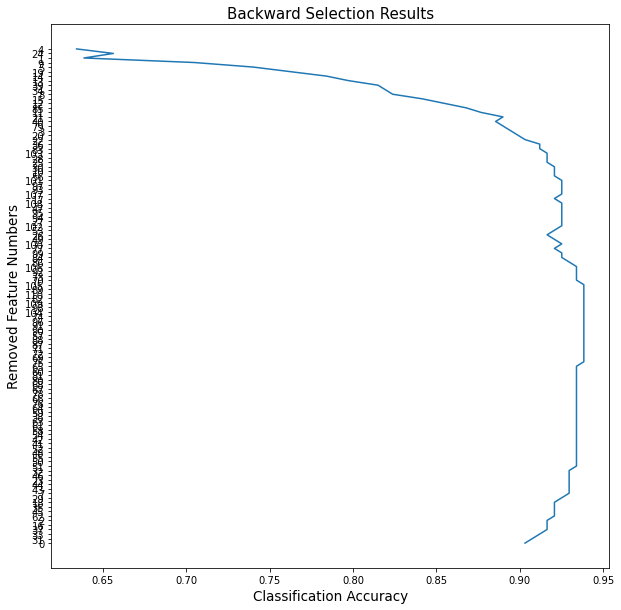

In [14]:
selected_features, accuracies, RF = backward_elimination(train_data, test_data, train_labels, test_labels)

In [15]:
print('Num of Selected Features:',len(selected_features))
print('Selected Features:\n%s'% np.array(selected_features))
print('\n')
print('Num of Removed Features:',len(RF))
print('Removed Feature:\n%s '% np.array(RF))

Num of Selected Features: 70
Selected Features:
[  1   3   4   5   6   8   9  10  11  12  13  14  15  17  19  20  21  22
  24  25  26  27  28  30  34  36  39  40  47  49  53  56  57  69  70  71
  72  73  74  77  79  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]


Num of Removed Features: 110
Removed Feature:
[  0  31  33  37  16   2  62  45  35  18  29   7  43  44  23  46  32  51
  50  55  48  52  41  42  54  58  61  63  38  59  64  76  66  78  67  68
  80  81  60  65  75  69  72  71  87  88  57  90  91  96  74 104  98 109
  82 110  89 105  70  73  92 106  86  84  99  77 100  49  26  53 102  27
  94  95  47 108  17 107  93  97 101  56  10  30  25  28 103  83  36  22
  20   3  79  40  21  11  85  12  15   8  34  39  13  14  19   5   9   1
  24   4] 


In [16]:
l = len(RF)-len(selected_features)+1
np.sort(RF[:l])

array([ 0,  2,  7, 16, 18, 23, 29, 31, 32, 33, 35, 37, 38, 41, 42, 43, 44,
       45, 46, 48, 50, 51, 52, 54, 55, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 75, 76, 78, 80, 81])

In [17]:
df_train_new = pd.DataFrame(data = X_train_transformed)
df_train_new.drop(np.sort(RF[:l]), axis=1, inplace=True)
np.array(df_train_new).shape

(796, 70)

In [18]:
df_test_new = pd.DataFrame(data = X_test_transformed)
df_test_new.drop(np.sort(RF[:l]), axis=1, inplace=True)
np.array(df_test_new).shape

(227, 70)

In [19]:
train_data_new = np.array(df_train_new)
train_labels = np.array(y_train_SMOTE)
test_data_new = np.array(df_test_new)
test_labels = np.array(y_test)

## Evaluation Metrics

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def evaluation(test_labels, predicted):
    confusion_mtx = confusion_matrix(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)
    f1score = f1_score(test_labels, predicted)
    report = classification_report(test_labels, predicted)

    FP = confusion_mtx.sum(axis=0) - np.diag(confusion_mtx)  
    FN = confusion_mtx.sum(axis=1) - np.diag(confusion_mtx)
    TP = np.diag(confusion_mtx)
    TN = confusion_mtx.sum() - (FP + FN + TP)
    
    recall = TP/(TP+FN)  # Sensitivity, hit rate, recall, or true positive rate   
    precision = TP/(TP+FP)  # Precision or positive predictive value
    
    print("Accuracy = {0:0.2f}".format(accuracy))
    print("Sensitivity = {0:0.2f}".format(recall[1]))
    print("Precision = {0:0.2f}".format(precision[1]))
    print("F1_score = {0:0.2f}".format(f1score))
    print('\n')
    print("Confusion matrix:\n%s" % confusion_mtx)

In [38]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def plot_ROC(y_test, y_pred):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure(figsize=(5,3.5))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=13)
    plt.ylabel('True Positive Rate',fontsize=13)
    plt.title('Receiver Operating Characteristic',fontsize=14)
    plt.legend(loc="lower right",fontsize=12)
    plt.savefig('Log_ROC')
    plt.show()

## Logistic regression

Accuracy = 0.81
Sensitivity = 0.86
Precision = 0.88
F1_score = 0.87


Confusion matrix:
[[ 42  19]
 [ 24 142]]


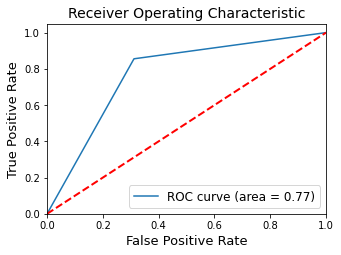

In [39]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

## SVM

In [40]:
from sklearn import svm
#'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

Accuracy = 0.89
Sensitivity = 0.95
Precision = 0.91
F1_score = 0.93


Confusion matrix:
[[ 46  15]
 [  9 157]]


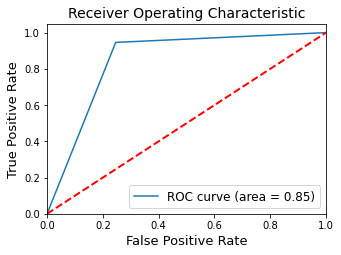

In [41]:
clf = svm.SVC(kernel='rbf')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.89
Sensitivity = 0.93
Precision = 0.92
F1_score = 0.92


Confusion matrix:
[[ 47  14]
 [ 12 154]]


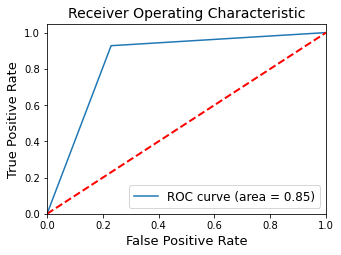

In [42]:
clf = svm.SVC(kernel='poly')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.80
Sensitivity = 0.84
Precision = 0.88
F1_score = 0.86


Confusion matrix:
[[ 42  19]
 [ 26 140]]


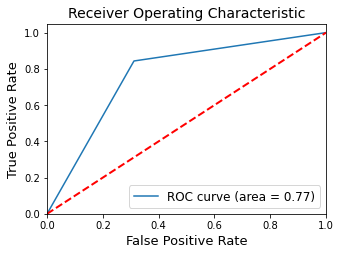

In [43]:
clf = svm.SVC(kernel='linear')
clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.70
Sensitivity = 0.80
Precision = 0.79
F1_score = 0.80


Confusion matrix:
[[ 26  35]
 [ 33 133]]


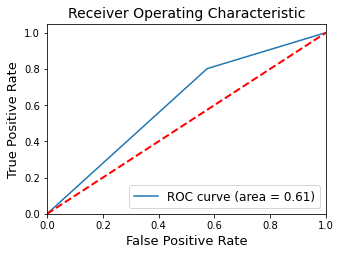

In [44]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_labels)
predicted = clf.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

different_k = np.array([1,2,3,4,5,6,7,8,9,10])

CCR_knn = []
for i in different_k:
    knn = KNeighborsClassifier(n_neighbors=i).fit(train_data, train_labels)
    predicted = knn.predict(test_data)
    CCR_knn.append(accuracy_score(test_labels, predicted))
    #print(i)
    #print(CCR_knn)

k_opt = different_k[CCR_knn.index(max(CCR_knn))]
print('k_opt =',k_opt)

k_opt = 1


Accuracy = 0.86
Sensitivity = 0.88
Precision = 0.93
F1_score = 0.90


Confusion matrix:
[[ 50  11]
 [ 20 146]]


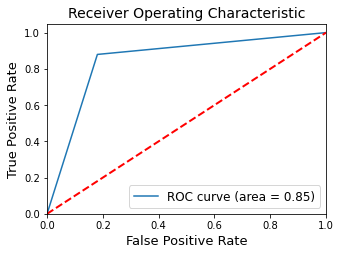

In [46]:
k = k_opt
knn = KNeighborsClassifier(n_neighbors=k_opt).fit(train_data, train_labels)
predicted = knn.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

In [47]:
from sklearn.mixture import GaussianMixture
# 'full', 'tied', 'diag', 'spherical'

Accuracy = 0.81
Sensitivity = 0.97
Precision = 0.81
F1_score = 0.88


Confusion matrix:
[[ 23  38]
 [  5 161]]


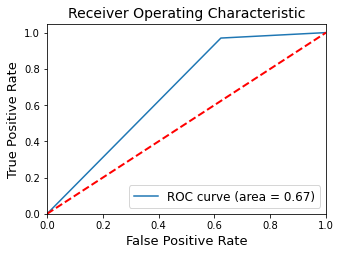

In [48]:
GMM = GaussianMixture(n_components=2, covariance_type='full').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.83
Sensitivity = 0.92
Precision = 0.85
F1_score = 0.89


Confusion matrix:
[[ 35  26]
 [ 13 153]]


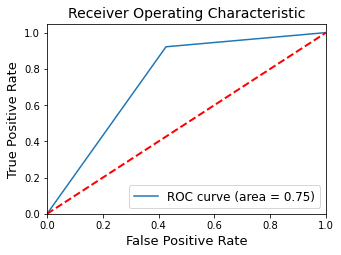

In [49]:
GMM = GaussianMixture(n_components=2, covariance_type='tied').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

Accuracy = 0.80
Sensitivity = 0.89
Precision = 0.85
F1_score = 0.87


Confusion matrix:
[[ 34  27]
 [ 18 148]]


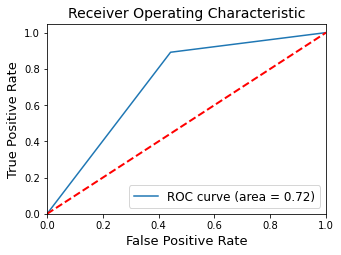

In [50]:
GMM = GaussianMixture(n_components=2, covariance_type='spherical').fit(train_data)
predicted = GMM.predict(test_data)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)

In [51]:
from sklearn.neighbors import KernelDensity
# 'gaussian'|'tophat'|'epanechnikov'|'exponential'|'linear'|'cosine'

In [52]:
classes = []
for i in range(0, 2):
    index = np.where(train_labels == i)[0]
    classes.append(train_data[index])

n = test_data.shape[0]
bandwidth = np.array([0.1,0.5,1,2,5,10]) 
accuracy = []
for i in bandwidth:
    kde0 = KernelDensity(bandwidth=i, kernel='gaussian')
    kde0 = kde0.fit(classes[0])
    logprob0 = kde0.score_samples(test_data)
    kde1 = KernelDensity(bandwidth=i, kernel='gaussian')
    kde1 = kde1.fit(classes[1])
    logprob1 = kde1.score_samples(test_data)
    predicted_labels = []
    for i in range (n):
        if np.exp(logprob0[i]) > np.exp(logprob1[i]):
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    CCR = np.sum(test_labels.T==predicted_labels)/len(predicted_labels)
    accuracy.append(CCR)
    
h_opt = bandwidth[accuracy.index(max(accuracy))]
print('h_opt =',h_opt)    

h_opt = 0.5


Accuracy = 0.83
Sensitivity = 0.83
Precision = 0.93
F1_score = 0.88


Confusion matrix:
[[ 51  10]
 [ 28 138]]


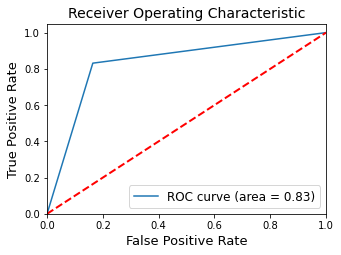

In [53]:
h = h_opt
kde0 = KernelDensity(bandwidth=h, kernel='gaussian').fit(classes[0])
logprob0 = kde0.score_samples(test_data)
kde1 = KernelDensity(bandwidth=h, kernel='gaussian').fit(classes[1])
logprob1 = kde1.score_samples(test_data)

predicted = []
for i in range (n):
    if np.exp(logprob0[i]) > np.exp(logprob1[i]):
        predicted.append(0)
    else:
        predicted.append(1)

evaluation(test_labels, predicted)
plot_ROC(test_labels, predicted)